In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras


import flwr as fl
import matplotlib.pyplot as plt
import numpy as np 
from typing import List, Tuple
from flwr.common import Metrics
import ray
#https://medium.com/mlearning-ai/evaluating-federated-learning-from-felt-labs-on-mnist-dataset-cbe081b28786
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()


2024-02-12 12:13:14.815100: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 12:13:14.838895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 12:13:14.838943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 12:13:14.840116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 12:13:14.845022: I tensorflow/core/platform/cpu_feature_guar

# Data Processing

In [2]:
def getMnistData():
    (traindataset,testDataset),datasetinfo = tfds.load(
        'mnist',
        split=['train','test'],
        shuffle_files= True,
        as_supervised= True,
        with_info= True
    )
    return traindataset,testDataset,datasetinfo

In [3]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        features.append(image)
        labels.append(label)
    return np.array(features), np.array(labels)

def Splitset(intrain,intest):
    Train_images, Train_label = dataset_to_numpy(intrain)
    Test_images, Test_label = dataset_to_numpy(intest)
    return  Train_images, Train_label,Test_images, Test_label

def datanorm(data):
    return data/255 

In [4]:
def split_intoPartition(data, num_partitions):
    # Calculate the size of each partition
    partition_size = len(data) // num_partitions
    # Split the dataset into partitions
    partitions = [data[i * partition_size:(i + 1) * partition_size] for i in range(num_partitions)]
    return partitions    

In [5]:
trainset,testset, info = getMnistData()
Train_images, Train_label,Test_images, Test_label = Splitset(trainset,testset)
Train_images_n = datanorm(Train_images)
Test_images_n = datanorm(Test_images)

2024-02-12 12:13:16.194271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 12:13:16.194444: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 12:13:16.194524: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

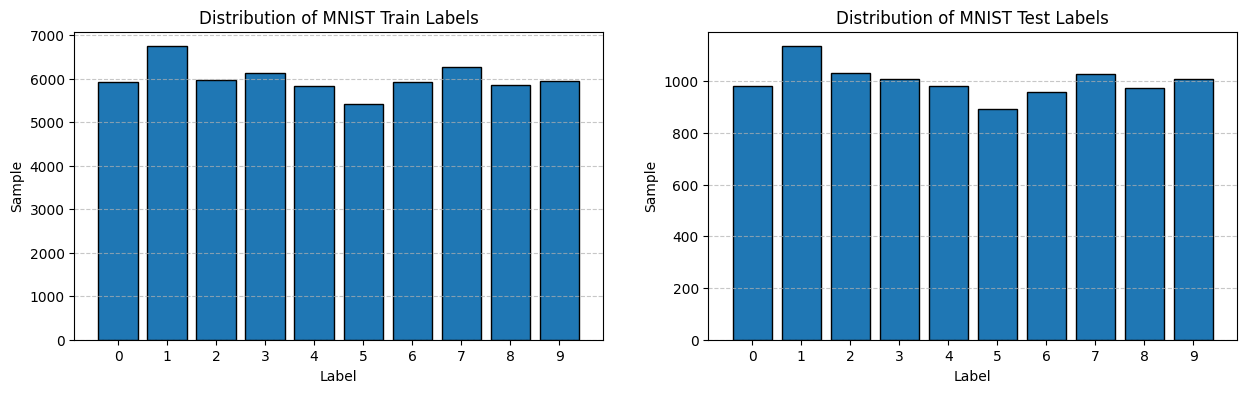

In [6]:
fig_1,axs_1 = plt.subplots(1,2,figsize = (15,4))
axs_1[0].hist(Train_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[0].set_title('Distribution of MNIST Train Labels')
axs_1[0].set_xlabel('Label')
axs_1[0].set_ylabel('Sample')
axs_1[0].set_xticks(range(10))  # Digits 0 to 9
axs_1[0].grid(axis='y', linestyle='--', alpha=0.7)

axs_1[1].hist(Test_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[1].set_title('Distribution of MNIST Test Labels')
axs_1[1].set_xlabel('Label')
axs_1[1].set_ylabel('Sample')
axs_1[1].set_xticks(range(10))  # Digits 0 to 9
axs_1[1].grid(axis='y', linestyle='--', alpha=0.7)


# Partition DataSet

In [7]:
NumOfPartition = 2
train_image_part = split_intoPartition(Train_images_n,NumOfPartition)
train_label_part = split_intoPartition(Train_label,NumOfPartition)

# train_image_part,train_label_part,test_image_part,test_label_part

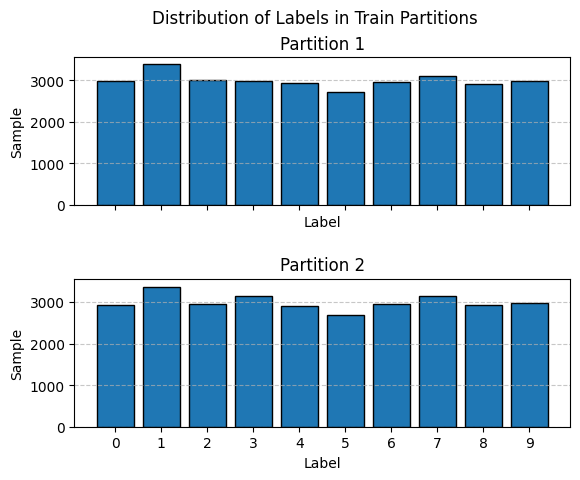

In [8]:
# Plot histogram for each partition
fig, axs = plt.subplots(NumOfPartition, sharex=True, sharey=True)

for i, partition in enumerate(train_label_part):
    axs[i].hist(partition, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black')
    axs[i].set_title(f'Partition {i + 1}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Sample')
    axs[i].set_xticks(range(10))
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Labels in Train Partitions')
plt.show()

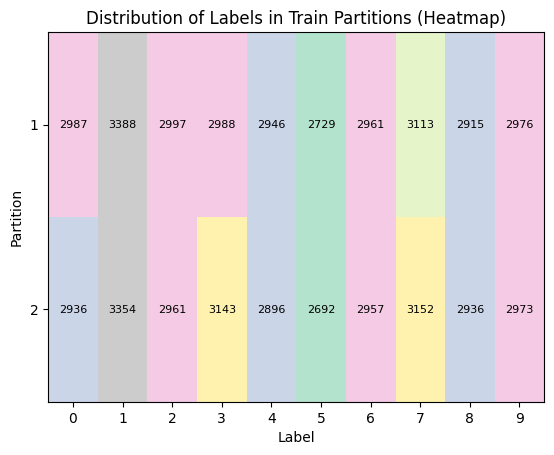

In [9]:
# Create an array to store the histogram data for each partition
hist_data = [np.histogram(partition, bins=range(11))[0] for partition in train_label_part]

# Plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(hist_data, cmap='Pastel2',aspect='auto', interpolation='none')

# Add annotations
for i in range(len(train_label_part)):
    for j in range(10):
        text = ax.text(j, i, hist_data[i][j], ha='center', va='center', color='black', fontsize=8)

# Set labels and ticks
ax.set_title('Distribution of Labels in Train Partitions (Heatmap)')
ax.set_xlabel('Label')
ax.set_ylabel('Partition')
ax.set_xticks(range(10))
ax.set_yticks(range(len(train_label_part)))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(1, len(train_label_part) + 1))

# Add colorbar
plt.colorbar(im, ax=ax).remove()

plt.show()

In [10]:
def customCNNModel():
    model = keras.Sequential()
    # First convolutional layer
    model.add(keras.layers.Conv2D(20, (3, 3), activation='relu', input_shape=(28,28,1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3),strides=(2,2)))
    # Flatten the output before the fully connected layers
    model.add(keras.layers.Flatten())
    # Fully connected layers
    model.add(keras.layers.Dense(100, activation='relu'))       
    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Client

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, train_x,train_y,val_x,val_y, model) -> None:
        super().__init__()
        self.train_feature_set = train_x
        self.train_label_set = train_y
        self.val_feature_set = val_x
        self.val_label_set = val_y
        self.model = model
        
    def get_parameters(self, config):
        return self.model.get_weights()
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print(f"round :{config['current_round']}")
        print(f"Train :{len(self.train_feature_set)}")
        print(f"Test :{len(self.val_feature_set)}")

        # Train the returned model
        TrainHistory = self.model.fit(x=self.train_feature_set, 
                                 y=self.train_label_set,
                                 verbose=2, 
                                 batch_size=config['batch_size'],
                                 epochs=config['local_epochs'],
                                 validation_data =(self.val_feature_set,self.val_label_set)
                                 )
        result ={
                "loss": TrainHistory.history['loss'][-1],
                "accuracy": round(TrainHistory.history['accuracy'][-1]*100,2),
                "val_loss" : TrainHistory.history['val_loss'][-1],
                "val_accuracy"  : round(TrainHistory.history["val_accuracy"][-1]*100,2),
        }

        print("Client Train and validate Done!!!")       
        # Send local model to server to do aggreation
        return self.model.get_weights(), len(self.train_feature_set),result

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # Test Global model
        loss, accuracy = self.model.evaluate(self.val_feature_set,
                                        self.val_label_set,
                                        batch_size=config['batch_size'],
                                        verbose=2)
        print("Global Validate Done!!!")       
        return loss, len(self.val_feature_set), {"accuracy": round(float(accuracy*100),2)}


def generate_client_fn(train_x,train_y,val_x,val_y, model):
    """Return a function to construct a FlowerClient."""

    def client_fn(cid: str):
        print
        return FlowerClient(train_x[int(cid)],train_y[int(cid)],val_x,val_y,model)
    return client_fn


# Server

In [12]:
# config for Client using Server side
def fit_config(server_round: int):
    """Return training configuration dict for each round."""
    config = {
        "batch_size": 32,
        "current_round": server_round,
        "local_epochs": 50,
    }
    return config

def evalute_config(server_round: int):
    """Return test configuration dict for each round."""
    config = {
        "batch_size": 1,
        "current_round": server_round,
    }
    return config

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def fit_average(metric):
    examples = [num_examples for num_examples, _ in metric]
    trainacc = [num_examples * m["accuracy"] for num_examples, m in metric]
    valacc = [num_examples * m["val_accuracy"] for num_examples, m in metric]
    
    return { "example": sum(examples),
            "accuracy": sum(trainacc) / sum(examples),
            "valacc": sum(valacc) / sum(examples)
            }





In [13]:
Fedavgconfig = fl.server.strategy.FedAvg(on_fit_config_fn=fit_config,
                                         on_evaluate_config_fn=evalute_config,
                                         evaluate_metrics_aggregation_fn=weighted_average,
                                         fit_metrics_aggregation_fn=fit_average,
                                         min_evaluate_clients= NumOfPartition,
                                         min_fit_clients=NumOfPartition,
                                         min_available_clients=NumOfPartition,
                                        )

# Simulation

In [14]:
globalmodel = customCNNModel()
clientfn = generate_client_fn(train_image_part,train_label_part,Test_images_n,Test_label,globalmodel)

In [15]:
history = fl.simulation.start_simulation(
        client_fn=clientfn,
        num_clients=NumOfPartition,
        config=fl.server.ServerConfig(num_rounds=10),
        strategy=Fedavgconfig,
        ray_init_args ={
            "include_dashboard": True, # we need this one for tracking,
        },
        actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth # <-- To be executed upon actor init.
    },
        client_resources = {'num_cpus': 8, 'num_gpus': 1}, # A Python dict specifying CPU/GPU resources
    )

INFO flwr 2024-02-12 12:13:22,123 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-12 12:13:23,740	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2024-02-12 12:13:24,381 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3873517977.0, 'CPU': 16.0, 'accelerator_type:G': 1.0, 'node:192.168.1.100': 1.0, 'GPU': 1.0, 'memory': 7747035956.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3873517977.0, 'CPU': 16.0, 'accelerator_type:G': 1.0, 'node:192.168.1.100': 1.0, 'GPU': 1.0, 'memory': 7747035956.0}
INFO flwr 2024-02-12 12:13:24,382 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Opti

(DefaultActor pid=157179) round :1
(DefaultActor pid=157179) Train :30000
(DefaultActor pid=157179) Test :10000
(DefaultActor pid=157179) Epoch 1/50


(DefaultActor pid=157179) 2024-02-12 12:13:26.512661: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
(DefaultActor pid=157179) 2024-02-12 12:13:26.558617: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
(DefaultActor pid=157179) 2024-02-12 12:13:26.716534: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
(DefaultActor pid=157179) 2024-02-12 12:13:26.766781: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f01282f64b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(DefaultActor pid=157179) 2024-02-12 12:13:26.766809: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
(DefaultActor pid=157179) 2024-02-12 12:13:26.771344: I tensorflow/compiler/mlir/tensorflow/uti

(DefaultActor pid=157179) 938/938 - 3s - loss: 0.2323 - accuracy: 0.9321 - val_loss: 0.0840 - val_accuracy: 0.9724 - 3s/epoch - 3ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 1s - loss: 0.0759 - accuracy: 0.9774 - val_loss: 0.0745 - val_accuracy: 0.9756 - 1s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0521 - accuracy: 0.9838 - val_loss: 0.0509 - val_accuracy: 0.9834 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0396 - accuracy: 0.9875 - val_loss: 0.0561 - val_accuracy: 0.9827 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0299 - accuracy: 0.9907 - val_loss: 0.0511 - val_accuracy: 0.9843 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 6/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0253 - accuracy: 0.9913 - val_loss: 0.0534 - val_accuracy: 0.9814 - 2s/epoch - 2m

(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.2298 - accuracy: 0.9309 - val_loss: 0.0905 - val_accuracy: 0.9718 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0777 - accuracy: 0.9763 - val_loss: 0.0591 - val_accuracy: 0.9800 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0536 - accuracy: 0.9837 - val_loss: 0.0643 - val_accuracy: 0.9782 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0402 - accuracy: 0.9871 - val_loss: 0.0480 - val_accuracy: 0.9838 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0284 - accuracy: 0.9908 - val_loss: 0.0494 - val_accuracy: 0.9828 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 6/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0223 - accuracy: 0.9925 - val_loss: 0.0485 -

DEBUG flwr 2024-02-12 12:16:24,849 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:16:24,853 | server.py:173 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 938/938 - 2s - loss: 5.2927e-05 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9880 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Client Train and validate Done!!!
(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.0601 - accuracy: 0.9885 - 6s/epoch - 648us/step
(DefaultActor pid=157179) Global Validate Done!!!


(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 12:16:37,856 | server.py:187 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:16:37,857 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.0601 - accuracy: 0.9885 - 6s/epoch - 622us/step
(DefaultActor pid=157179) Global Validate Done!!!
(DefaultActor pid=157179) round :2
(DefaultActor pid=157179) Train :30000
(DefaultActor pid=157179) Test :10000
(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0156 - accuracy: 0.9953 - val_loss: 0.0550 - val_accuracy: 0.9873 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.0543 - val_accuracy: 0.9881 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0524 - val_accuracy: 0.9891 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.0583 - val_accuracy: 0.9880 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(Def

(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.0527 - val_accuracy: 0.9876 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0453 - val_accuracy: 0.9892 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 5.0830e-04 - accuracy: 0.9999 - val_loss: 0.0522 - val_accuracy: 0.9875 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0665 - val_accuracy: 0.9847 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.0580 - val_accuracy: 0.9869 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 6/50
(DefaultActor pid=157179) 938/938 - 1s - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.05

DEBUG flwr 2024-02-12 12:19:33,631 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:19:33,634 | server.py:173 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 938/938 - 2s - loss: 1.3907e-06 - accuracy: 1.0000 - val_loss: 0.0782 - val_accuracy: 0.9888 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Client Train and validate Done!!!
(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.0707 - accuracy: 0.9903 - 6s/epoch - 615us/step
(DefaultActor pid=157179) Global Validate Done!!!


(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 12:19:46,446 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:19:46,446 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.0707 - accuracy: 0.9903 - 6s/epoch - 638us/step
(DefaultActor pid=157179) Global Validate Done!!!
(DefaultActor pid=157179) round :3
(DefaultActor pid=157179) Train :30000
(DefaultActor pid=157179) Test :10000
(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.0700 - val_accuracy: 0.9884 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.0747 - val_accuracy: 0.9876 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 1.4809e-04 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9899 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 1.9807e-05 - accuracy: 1.0000 - val_loss: 0.0640 - val_accuracy: 0.9900 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5

(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0673 - val_accuracy: 0.9880 - 2s/epoch - 3ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.0843 - val_accuracy: 0.9872 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0663 - val_accuracy: 0.9898 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0677 - val_accuracy: 0.9894 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 8.4511e-04 - accuracy: 0.9996 - val_loss: 0.0774 - val_accuracy: 0.9893 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 6/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.08

DEBUG flwr 2024-02-12 12:22:45,801 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:22:45,803 | server.py:173 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 3: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 938/938 - 2s - loss: 5.6426e-10 - accuracy: 1.0000 - val_loss: 0.1095 - val_accuracy: 0.9891 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Client Train and validate Done!!!
(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1022 - accuracy: 0.9901 - 6s/epoch - 623us/step
(DefaultActor pid=157179) Global Validate Done!!!


(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 12:22:58,480 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:22:58,481 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1022 - accuracy: 0.9901 - 6s/epoch - 616us/step
(DefaultActor pid=157179) Global Validate Done!!!
(DefaultActor pid=157179) round :4
(DefaultActor pid=157179) Train :30000
(DefaultActor pid=157179) Test :10000
(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0076 - accuracy: 0.9982 - val_loss: 0.0953 - val_accuracy: 0.9897 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0904 - val_accuracy: 0.9883 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0985 - val_accuracy: 0.9876 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0986 - val_accuracy: 0.9867 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(Def

(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.1225 - val_accuracy: 0.9876 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.1010 - val_accuracy: 0.9888 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 7.8663e-05 - accuracy: 1.0000 - val_loss: 0.1018 - val_accuracy: 0.9891 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 1.3145e-05 - accuracy: 1.0000 - val_loss: 0.0962 - val_accuracy: 0.9898 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 3.3135e-06 - accuracy: 1.0000 - val_loss: 0.0932 - val_accuracy: 0.9898 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 6/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 6.9939e-07 - accuracy: 1.0000 - va

DEBUG flwr 2024-02-12 12:25:57,994 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG:flwr:fit_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:25:57,996 | server.py:173 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 4: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 938/938 - 2s - loss: 9.5367e-11 - accuracy: 1.0000 - val_loss: 0.1198 - val_accuracy: 0.9904 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Client Train and validate Done!!!
(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1093 - accuracy: 0.9916 - 6s/epoch - 629us/step
(DefaultActor pid=157179) Global Validate Done!!!


(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 12:26:10,825 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:26:10,826 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 5: strategy sampled 2 clients (out of 2)


(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1093 - accuracy: 0.9916 - 6s/epoch - 625us/step
(DefaultActor pid=157179) Global Validate Done!!!


(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) round :5
(DefaultActor pid=157179) Train :30000
(DefaultActor pid=157179) Test :10000
(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.1273 - val_accuracy: 0.9872 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.1061 - val_accuracy: 0.9882 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0984 - val_accuracy: 0.9886 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1021 - val_accuracy: 0.9881 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.1157 - val_accuracy: 0.9862 - 2s/epoch - 2ms/step
(DefaultActor pid=

(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.1117 - val_accuracy: 0.9880 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 1.7658e-04 - accuracy: 0.9999 - val_loss: 0.0992 - val_accuracy: 0.9893 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0948 - val_accuracy: 0.9886 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.1248 - val_accuracy: 0.9862 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0858 - val_accuracy: 0.9899 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 6/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.09

DEBUG flwr 2024-02-12 12:29:09,998 | server.py:236 | fit_round 5 received 2 results and 0 failures
DEBUG:flwr:fit_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:29:10,000 | server.py:173 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 5: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 938/938 - 2s - loss: 2.7815e-11 - accuracy: 1.0000 - val_loss: 0.1188 - val_accuracy: 0.9900 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Client Train and validate Done!!!
(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1038 - accuracy: 0.9905 - 6s/epoch - 615us/step
(DefaultActor pid=157179) Global Validate Done!!!


(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 12:29:22,656 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:29:22,657 | server.py:222 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 6: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1038 - accuracy: 0.9905 - 6s/epoch - 624us/step
(DefaultActor pid=157179) Global Validate Done!!!
(DefaultActor pid=157179) round :6
(DefaultActor pid=157179) Train :30000
(DefaultActor pid=157179) Test :10000
(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.1129 - val_accuracy: 0.9889 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.1224 - val_accuracy: 0.9887 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.1073 - val_accuracy: 0.9889 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.1334 - val_accuracy: 0.9858 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(Def

(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.1120 - val_accuracy: 0.9889 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.1158 - val_accuracy: 0.9880 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 3.4985e-04 - accuracy: 0.9999 - val_loss: 0.1013 - val_accuracy: 0.9897 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 1s - loss: 5.8087e-04 - accuracy: 0.9999 - val_loss: 0.1331 - val_accuracy: 0.9846 - 1s/epoch - 1ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.1215 - val_accuracy: 0.9873 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 6/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 

DEBUG flwr 2024-02-12 12:32:19,422 | server.py:236 | fit_round 6 received 2 results and 0 failures
DEBUG:flwr:fit_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:32:19,426 | server.py:173 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 6: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 938/938 - 2s - loss: 5.5631e-11 - accuracy: 1.0000 - val_loss: 0.1306 - val_accuracy: 0.9892 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Client Train and validate Done!!!
(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1215 - accuracy: 0.9904 - 6s/epoch - 605us/step
(DefaultActor pid=157179) Global Validate Done!!!


(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 12:32:32,026 | server.py:187 | evaluate_round 6 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:32:32,027 | server.py:222 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 7: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1215 - accuracy: 0.9904 - 6s/epoch - 625us/step
(DefaultActor pid=157179) Global Validate Done!!!
(DefaultActor pid=157179) round :7
(DefaultActor pid=157179) Train :30000
(DefaultActor pid=157179) Test :10000
(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.1519 - val_accuracy: 0.9871 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.1701 - val_accuracy: 0.9867 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0011 - accuracy: 0.9995 - val_loss: 0.1367 - val_accuracy: 0.9882 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.1412 - val_accuracy: 0.9858 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(Def

(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.1318 - val_accuracy: 0.9887 - 2s/epoch - 3ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.1231 - val_accuracy: 0.9892 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.1442 - val_accuracy: 0.9853 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.1281 - val_accuracy: 0.9879 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.1286 - val_accuracy: 0.9869 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 6/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.1293 -

DEBUG flwr 2024-02-12 12:35:35,943 | server.py:236 | fit_round 7 received 2 results and 0 failures
DEBUG:flwr:fit_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:35:35,945 | server.py:173 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 7: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 938/938 - 2s - loss: 3.9736e-11 - accuracy: 1.0000 - val_loss: 0.1268 - val_accuracy: 0.9899 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Client Train and validate Done!!!
(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1124 - accuracy: 0.9911 - 6s/epoch - 634us/step
(DefaultActor pid=157179) Global Validate Done!!!


(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 12:35:49,001 | server.py:187 | evaluate_round 7 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:35:49,003 | server.py:222 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 8: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1124 - accuracy: 0.9911 - 6s/epoch - 641us/step
(DefaultActor pid=157179) Global Validate Done!!!
(DefaultActor pid=157179) round :8
(DefaultActor pid=157179) Train :30000
(DefaultActor pid=157179) Test :10000
(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.1486 - val_accuracy: 0.9883 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.1375 - val_accuracy: 0.9888 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.1318 - val_accuracy: 0.9884 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.1438 - val_accuracy: 0.9859 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(Def

(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.1240 - val_accuracy: 0.9902 - 2s/epoch - 3ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 1.6214e-05 - accuracy: 1.0000 - val_loss: 0.1148 - val_accuracy: 0.9908 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 2.7126e-07 - accuracy: 1.0000 - val_loss: 0.1123 - val_accuracy: 0.9908 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 8.1727e-08 - accuracy: 1.0000 - val_loss: 0.1121 - val_accuracy: 0.9907 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 6.3020e-08 - accuracy: 1.0000 - val_loss: 0.1122 - val_accuracy: 0.9906 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 6/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 5.0536e-08 - accuracy: 1.0000 

DEBUG flwr 2024-02-12 12:38:49,525 | server.py:236 | fit_round 8 received 2 results and 0 failures
DEBUG:flwr:fit_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:38:49,528 | server.py:173 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 8: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 938/938 - 2s - loss: 3.9736e-12 - accuracy: 1.0000 - val_loss: 0.1339 - val_accuracy: 0.9906 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Client Train and validate Done!!!
(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1242 - accuracy: 0.9906 - 6s/epoch - 625us/step
(DefaultActor pid=157179) Global Validate Done!!!


(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 12:39:02,213 | server.py:187 | evaluate_round 8 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:39:02,214 | server.py:222 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 9: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1242 - accuracy: 0.9906 - 6s/epoch - 616us/step
(DefaultActor pid=157179) Global Validate Done!!!
(DefaultActor pid=157179) round :9
(DefaultActor pid=157179) Train :30000
(DefaultActor pid=157179) Test :10000
(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.1551 - val_accuracy: 0.9882 - 2s/epoch - 3ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 6.2713e-04 - accuracy: 0.9999 - val_loss: 0.1462 - val_accuracy: 0.9890 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 8.6825e-04 - accuracy: 0.9998 - val_loss: 0.1520 - val_accuracy: 0.9890 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 1s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.1473 - val_accuracy: 0.9871 - 1s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5

(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.1498 - val_accuracy: 0.9884 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1428 - val_accuracy: 0.9881 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0035 - accuracy: 0.9994 - val_loss: 0.1442 - val_accuracy: 0.9882 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.1486 - val_accuracy: 0.9880 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.1259 - val_accuracy: 0.9889 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 6/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.1616 -

DEBUG flwr 2024-02-12 12:42:01,301 | server.py:236 | fit_round 9 received 2 results and 0 failures
DEBUG:flwr:fit_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:42:01,304 | server.py:173 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 9: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 938/938 - 2s - loss: 2.1855e-10 - accuracy: 1.0000 - val_loss: 0.1251 - val_accuracy: 0.9907 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Client Train and validate Done!!!
(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1275 - accuracy: 0.9912 - 6s/epoch - 638us/step
(DefaultActor pid=157179) Global Validate Done!!!


(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 12:42:14,120 | server.py:187 | evaluate_round 9 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:42:14,121 | server.py:222 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 10: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1275 - accuracy: 0.9912 - 6s/epoch - 614us/step
(DefaultActor pid=157179) Global Validate Done!!!
(DefaultActor pid=157179) round :10
(DefaultActor pid=157179) Train :30000
(DefaultActor pid=157179) Test :10000
(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 7.3664e-04 - accuracy: 0.9997 - val_loss: 0.1518 - val_accuracy: 0.9887 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.1352 - val_accuracy: 0.9900 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.1591 - val_accuracy: 0.9880 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.1348 - val_accuracy: 0.9898 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50

(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) Epoch 1/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.1705 - val_accuracy: 0.9870 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 2/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.1429 - val_accuracy: 0.9889 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 3/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 3.2553e-04 - accuracy: 0.9999 - val_loss: 0.1340 - val_accuracy: 0.9898 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 4/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.1234 - val_accuracy: 0.9900 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 5/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.1374 - val_accuracy: 0.9902 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Epoch 6/50
(DefaultActor pid=157179) 938/938 - 2s - loss: 3.6984e-04 - accuracy: 0.9999 - val_loss: 

DEBUG flwr 2024-02-12 12:45:19,417 | server.py:236 | fit_round 10 received 2 results and 0 failures
DEBUG:flwr:fit_round 10 received 2 results and 0 failures
DEBUG flwr 2024-02-12 12:45:19,421 | server.py:173 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 10: strategy sampled 2 clients (out of 2)
(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=157179) 938/938 - 2s - loss: 1.9868e-11 - accuracy: 1.0000 - val_loss: 0.1303 - val_accuracy: 0.9907 - 2s/epoch - 2ms/step
(DefaultActor pid=157179) Client Train and validate Done!!!
(DefaultActor pid=157179) 10000/10000 - 6s - loss: 0.1278 - accuracy: 0.9911 - 6s/epoch - 624us/step
(DefaultActor pid=157179) Global Validate Done!!!


(DefaultActor pid=157179) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 13 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 12:45:32,486 | server.py:187 | evaluate_round 10 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 2 results and 0 failures
INFO flwr 2024-02-12 12:45:32,487 | server.py:153 | FL finished in 1926.539978232
INFO:flwr:FL finished in 1926.539978232
INFO flwr 2024-02-12 12:45:32,488 | app.py:226 | app_fit: losses_distributed [(1, 0.060114454478025436), (2, 0.07074777036905289), (3, 0.10219114273786545), (4, 0.10930853337049484), (5, 0.10376904159784317), (6, 0.1214853897690773), (7, 0.11237046122550964), (8, 0.12424690276384354), (9, 0.1274503469467163), (10, 0.12782028317451477)]
INFO:flwr:app_fit: losses_distributed [(1, 0.060114454478025436), (2, 0.07074777036905289), (3, 0.10219114273786545), (4, 0.10930853337049484), (5, 0.10376904159784317), (6, 0.1214853897690773), (7, 0.1123704612

(DefaultActor pid=157179) 10000/10000 - 7s - loss: 0.1278 - accuracy: 0.9911 - 7s/epoch - 653us/step
(DefaultActor pid=157179) Global Validate Done!!!


In [16]:
Train_acc_result = [x[1] for x in history.metrics_distributed_fit['accuracy']]
Val_acc_result = [x[1] for x in history.metrics_distributed_fit['valacc']]
Test_acc_result = [x[1] for x in history.metrics_distributed['accuracy']]
iteration = [i for i in range(1,len(Train_acc_result)+1)]

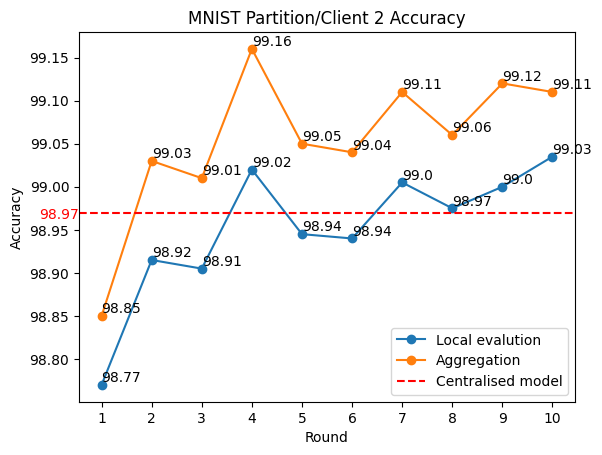

In [19]:
#plt.plot(iteration,Train_acc_result,marker='o',label="Train")
plt.title(f"MNIST Partition/Client {NumOfPartition} Accuracy")
plt.plot(iteration,Val_acc_result,marker='o',label="Local evalution")
plt.plot(iteration,Test_acc_result,marker='o',label="Aggregation")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(iteration)

for i, j in zip(iteration, Val_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')
for i, j in zip(iteration, Test_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')

average_value = 98.97
plt.gca().text(0, average_value/200, f"{average_value}", transform=plt.gca().transAxes, ha='right',color='r',)
plt.axhline(y=average_value, color='r', linestyle='--', label='Centralised model')

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.legend()

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.show()